**Yolo_v3 From Scratch**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,random_split
from torchvision import transforms

from PIL import Image,ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from tqdm import tqdm

import xml.etree.ElementTree as ET

import wandb
import time
import os
from collections import Counter

/opt/conda/envs/idm/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
def iou(box1, box2, is_pred=True):
    if is_pred:
        # Prediction box
        b1_x1 = box1[..., 0:1] - box1[..., 2:3] / 2
        b1_y1 = box1[..., 1:2] - box1[..., 3:4] / 2
        b1_x2 = box1[..., 0:1] + box1[..., 2:3] / 2
        b1_y2 = box1[..., 1:2] + box1[..., 3:4] / 2

        # Ground Truth box
        b2_x1 = box2[..., 0:1] - box2[..., 2:3] / 2
        b2_y1 = box2[..., 1:2] - box2[..., 3:4] / 2
        b2_x2 = box2[..., 0:1] + box2[..., 2:3] / 2
        b2_y2 = box2[..., 1:2] + box2[..., 3:4] / 2

        # Intersection rectangle
        x1 = torch.max(b1_x1, b2_x1)
        y1 = torch.max(b1_y1, b2_y1)
        x2 = torch.min(b1_x2, b2_x2)
        y2 = torch.min(b1_y2, b2_y2)
        intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

        box1_area = abs((b1_x2 - b1_x1) * (b1_y2 - b1_y1))
        box2_area = abs((b2_x2 - b2_x1) * (b2_y2 - b2_y1))
        union = box1_area + box2_area - intersection

        epsilon = 1e-6
        iou_score = intersection / (union + epsilon)

        return iou_score
    else:
        # Intersection Area
        intersection_area = torch.min(box1[..., 0], box2[..., 0]) * torch.min(
            box1[..., 1], box2[..., 1]
        )

        box1_area = box1[..., 0] * box1[..., 1]
        box2_area = box2[..., 0] * box2[..., 1]
        union_area = box1_area + box2_area - intersection_area
        iou_score = intersection_area / (union_area + 1e-6)
        return iou_score

In [3]:
def nms(bboxes, iou_threshold, confidence_threshold):
    # Filter by confidence
    bboxes = [box for box in bboxes if box[1] > confidence_threshold]

    # Sort by confidence (descending)
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)

    boxes_after_nms = []

    while bboxes:
        # Select top-confidence box
        selected_box = bboxes.pop(0)
        boxes_after_nms.append(selected_box)

        # Compare with remaining boxes
        remaining_boxes = []
        for box in bboxes:
            # Calculate IoU between selected box and current box
            iou_score = iou(
                torch.tensor(selected_box[2:]), torch.tensor(box[2:]), is_pred=True
            )

            # Keep only boxes with IoU < threshold
            if iou_score < iou_threshold:
                remaining_boxes.append(box)

        bboxes = remaining_boxes

    return boxes_after_nms

In [25]:
def convert_cells_to_bboxes(predictions,anchors,s,is_predictions=True):
    batch_size = predictions.shape[0]
    num_anchors = len(anchors)

    box_predictions = predictions[...,1:5]

    if is_predictions:
        anchors = anchors.reshape(1,len(anchors),1,1,2)
        box_predictions[...,0:2] = torch.sigmoid(box_predictions[...,0:2])
        box_predictions[...,2:] = torch.exp(box_predictions[...,2:]) * anchors
        scores = torch.sigmoid(predictions[...,0:1])
        best_class = torch.argmax(predictions[...,5:],dim=-1).unsqueeze(-1).float()
    else:
        scores = predictions[...,0:1]
        best_class = predictions[...,5:6]

    cell_indices = (
        torch.arange(s)
        .repeat(predictions.shape[0],3,s,1)
        .unsqueeze(-1)
        .to(predictions.device)
    )
    x = 1/s*(box_predictions[...,0:1] + cell_indices)
    y = 1 / s * (box_predictions[..., 1:2] + cell_indices.permute(0, 1, 3, 2, 4))
    width_height = 1 / s * box_predictions[..., 2:4] 

    converted_bboxes = torch.cat(
        (best_class, scores, x, y, width_height), dim=-1
    ).reshape(batch_size, num_anchors * s * s, 6)

    return converted_bboxes.tolist()

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

load_model = False
save_model = True

checkpoint_file = "my_checkpoint.pth.tar"

ANCHORS = [
    [(0.28, 0.22), (0.38, 0.48), (0.9, 0.78)],
    [(0.07, 0.15), (0.15, 0.11), (0.14, 0.29)],
    [(0.02, 0.03), (0.04, 0.07), (0.08, 0.06)],
]

batch_size = 32
learning_rate = 5e-5
epochs = 20
image_size = 416
s = [image_size // 32, image_size // 16, image_size // 8]

class_labels = [
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "pottedplant",
    "sheep",
    "sofa",
    "train",
    "tvmonitor",
]

In [10]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch


def plot_image_with_ground_truth(
    image_tensor, targets_tuple, anchors, grid_sizes, class_labels
):
    img_np = image_tensor.permute(1, 2, 0).cpu().numpy()
    img_np = np.clip(img_np, 0.0, 1.0)

    color_map = plt.get_cmap("tab20b")
    colors = [color_map(i) for i in np.linspace(0, 1, len(class_labels))]

    h, w, _ = img_np.shape
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(img_np)

    for scale_idx, target in enumerate(targets_tuple):
        S = grid_sizes[scale_idx]
        target = target.cpu()
        obj_indices = torch.nonzero(target[..., 0] == 1, as_tuple=False)

        for anchor_on_scale, i, j in obj_indices:
            box_data = target[anchor_on_scale, i, j, :]
            x_cell, y_cell, w_cell, h_cell, class_id = box_data[1:]

            img_rel_x = (j.float() + x_cell) / S
            img_rel_y = (i.float() + y_cell) / S
            img_rel_w = w_cell / S
            img_rel_h = h_cell / S

            upper_left_x = img_rel_x - img_rel_w / 2
            upper_left_y = img_rel_y - img_rel_h / 2

            try:
                cls_int = int(class_id)
                if cls_int >= len(colors):
                    print(
                        f"Warning: class_id {cls_int} out of bounds for colors list (len={len(colors)}). Using color 0."
                    )
                    cls_int = 0

                rect = patches.Rectangle(
                    (upper_left_x * w, upper_left_y * h),
                    img_rel_w * w,
                    img_rel_h * h,
                    linewidth=2,
                    edgecolor=colors[cls_int],
                    facecolor="none",
                )
                ax.add_patch(rect)

                if cls_int < len(class_labels):
                    ax.text(
                        upper_left_x * w,
                        upper_left_y * h - 5,
                        s=class_labels[cls_int],
                        color="white",
                        verticalalignment="bottom",
                        bbox={"color": colors[cls_int], "pad": 0},
                    )
                else:
                    print(
                        f"Warning: class_id {cls_int} out of bounds for class_labels list (len={len(class_labels)})."
                    )

            except IndexError:
                print(f"Error accessing color/label for class_id: {class_id}")
                continue
            except ValueError:
                print(f"Error converting class_id to int: {class_id}")
                continue

    plt.axis("off")
    plt.tight_layout()
    plt.show()

In [8]:
def save_checkpoint(model,optimizer,file_name="my_checkpoint.pth"):
    print("=> Saving checkpoint")
    checkpoint = {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
    }
    torch.save(checkpoint, file_name)


def load_checkpoint(checkpoint_file,model,optimizer,lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    
    for param in optimizer.param_groups:
        param["lr"] = lr    

In [9]:
class ObjectDetectionDataset(Dataset):
    def __init__(
        self,
        image_dir,
        label_dir,
        anchors,
        image_size=416,
        grid_sizes=[13, 26, 52],
        num_classes=20,
        transform=None,
    ):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.image_size = image_size
        self.transform = transform
        self.grid_sizes = grid_sizes
        self.anchors = torch.tensor(anchors[0] + anchors[1] + anchors[2])
        self.num_anchors = self.anchors.shape[0]
        self.num_anchors_per_scale = self.num_anchors // 3
        self.num_classes = num_classes
        self.ignore_iou_threshold = 0.5
        self.class_to_idx = {cls: i for i, cls in enumerate(class_labels)}

        label_files = [
            f for f in os.listdir(self.label_dir) if f.lower().endswith(".xml")
        ]
        self.samples = []

        for xml_files in label_files:
            base_name = xml_files.split(".")[0]
            image_path = os.path.join(self.image_dir, base_name + ".jpg")
            xml_path = os.path.join(self.label_dir, base_name + ".xml")

            self.samples.append((image_path, xml_path))

        self.num_samples = len(self.samples)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        if idx >= self.num_samples:
            raise IndexError(
                f"Index {idx} out of bounds for dataset with size {self.num_samples}"
            )

        img_path, xml_path = self.samples[idx]

        bboxes = []
        try:
            tree = ET.parse(xml_path)
            root = tree.getroot()
            size_ele = root.find("size")
            img_width = float(size_ele.find("width").text)
            img_height = float(size_ele.find("height").text)

            for obj in root.findall("object"):
                class_name = obj.find("name").text

                if class_name not in self.class_to_idx:
                    # Ignoring it cos idc
                    continue
                class_id = self.class_to_idx[class_name]
                bndbox = obj.find("bndbox")
                x_min = float(bndbox.find("xmin").text)
                y_min = float(bndbox.find("ymin").text)
                x_max = float(bndbox.find("xmax").text)
                y_max = float(bndbox.find("ymax").text)

                xmin = max(0, x_min)
                ymin = max(0, y_min)
                xmax = min(img_width, x_max)
                ymax = min(img_height, y_max)

                box_width = xmax - xmin
                box_height = ymax - ymin

                center_x = (xmin + xmax) / 2
                center_y = (ymin + ymax) / 2
                norm_center_x = center_x / img_width
                norm_center_y = center_y / img_height
                norm_width = box_width / img_width
                norm_height = box_height / img_height

                bboxes.append(
                    [
                        norm_center_x,
                        norm_center_y,
                        norm_width,
                        norm_height,
                        class_id,
                    ]
                )
        except FileNotFoundError:
            print(f"Error parsing XML file: {xml_path}")
            raise FileNotFoundError("Annotation file not found: {xml_path}")

        try:
            image = np.array(Image.open(img_path).convert("RGB"))
        except FileNotFoundError:
            print(f"Error loading image file: {img_path}")
            raise FileNotFoundError("Image file not found: {img_path}")

        if self.transform:
            try:
                augs = self.transform(image=image, bboxes=bboxes)
                image = augs["image"]
                bboxes = augs["bboxes"]

            except Exception as e:
                print("Error during transformations for the image: {img_path}")
                raise e

        # Create target tensor
        targets = [
            torch.zeros((self.num_anchors_per_scale, s, s, 6)) for s in self.grid_sizes
        ]

        for box in bboxes:
            iou_anchors = iou(
                torch.tensor(box[2:4]),
                self.anchors,
                is_pred=False,
            )

            anchor_indices = iou_anchors.argsort(descending=True, dim=0)
            x, y, width, height, class_label = box

            if width <= 0 or height <= 0:
                continue

            has_anchor = [False] * 3

            for anchor_idx in anchor_indices:
                scale_idx = anchor_idx // self.num_anchors_per_scale
                anchor_on_scale = anchor_idx % self.num_anchors_per_scale
                s = self.grid_sizes[scale_idx]
                # Prevent potential index out of bounds from bad coordinates after transform
                i, j = min(s - 1, int(s * y)), min(s - 1, int(s * x))

                anchor_taken = targets[scale_idx][anchor_on_scale, i, j, 0]

                if not anchor_taken and not has_anchor[scale_idx]:
                    targets[scale_idx][anchor_on_scale, i, j, 0] = 1
                    x_cell, y_cell = s * x - j, s * y - i
                    width_cell, height_cell = (width * s, height * s)

                    box_coordinates = torch.tensor(
                        [x_cell, y_cell, width_cell, height_cell]
                    )
                    targets[scale_idx][anchor_on_scale, i, j, 1:5] = box_coordinates
                    targets[scale_idx][anchor_on_scale, i, j, 5] = int(class_label)
                    has_anchor[scale_idx] = True

                elif (
                    not anchor_taken
                    and iou_anchors[anchor_idx] > self.ignore_iou_threshold
                ):
                    targets[scale_idx][anchor_on_scale, i, j, 0] = -1

        return image, tuple(targets)

In [11]:
train_transform = A.Compose(
    [
        A.LongestMaxSize(max_size=image_size),
        A.PadIfNeeded(
            min_height=image_size,
            min_width=image_size,
            border_mode=cv2.BORDER_CONSTANT,
            value=[0, 0, 0], 
        ),
        A.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5, p=0.5),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format="yolo", min_visibility=0.4, label_fields=[]),
)

test_transform = A.Compose(
    [
        A.LongestMaxSize(max_size=image_size),
        A.PadIfNeeded(
            min_height=image_size,
            min_width=image_size,
            border_mode=cv2.BORDER_CONSTANT,
            value=[0, 0, 0],  
        ),
        A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format="yolo", min_visibility=0.4, label_fields=[]),
)

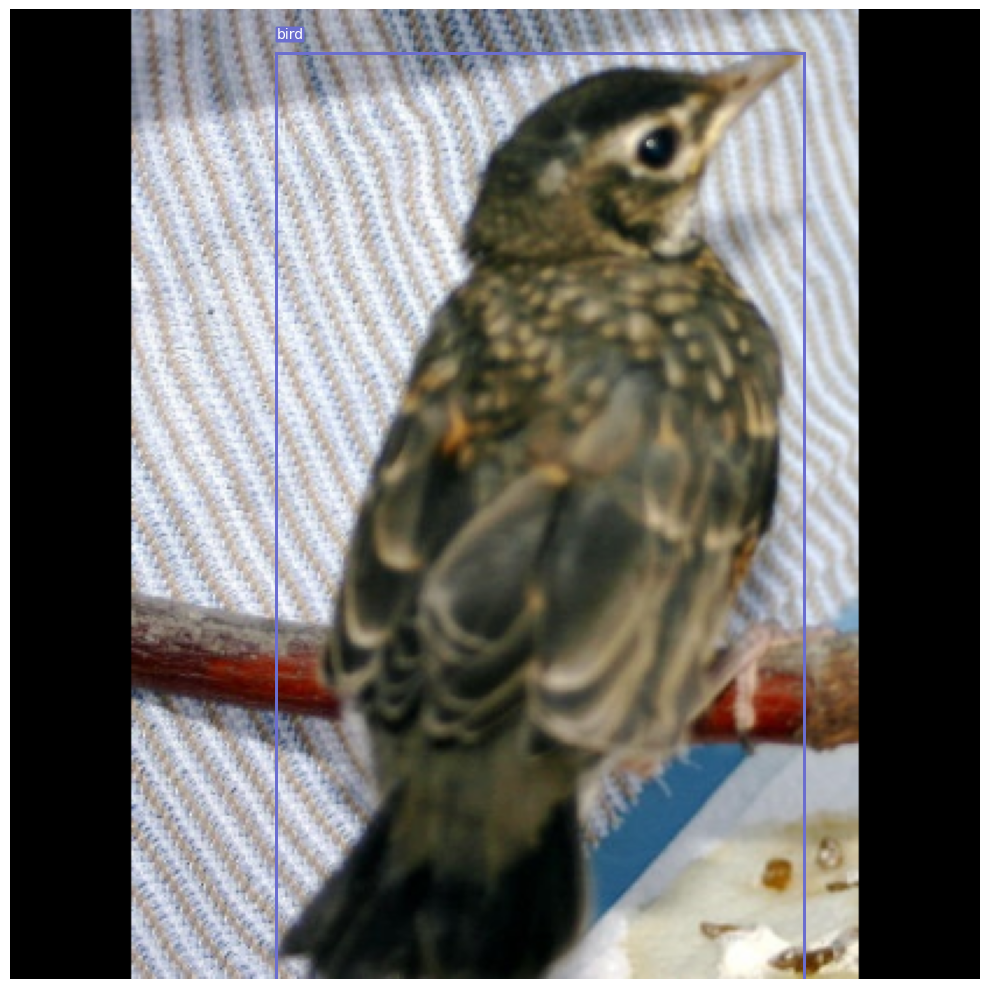

In [12]:
IMAGE_DIR = "VOCdevkit/VOC2007/JPEGImages"
LABEL_DIR = "VOCdevkit/VOC2007/Annotations"

train_dataset = ObjectDetectionDataset(
    image_dir=IMAGE_DIR,
    label_dir=LABEL_DIR,
    anchors=ANCHORS, 
    transform=train_transform,  
)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size, 
    shuffle=True,
    num_workers=4, 
    pin_memory=True,
)
image_tensor, targets_tuple = train_dataset[0]
plot_image_with_ground_truth(image_tensor, targets_tuple, ANCHORS, s, class_labels)

In [14]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_batch_norm=True, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(
            in_channels, out_channels, bias=not use_batch_norm, **kwargs
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.LeakyReLU(0.1)
        self.use_batch_norm = use_batch_norm

    def forward(self, x):
        x = self.conv(x)
        if self.use_batch_norm:
            x = self.bn(x)
            return self.activation(x)
        else:
            return x


class ResidualBlock(nn.Module):
    def __init__(self, channels, use_residual=True, num_repeats=1):
        super().__init__()

        res_layers = []
        for _ in range(num_repeats):
            res_layers += [
                nn.Sequential(
                    nn.Conv2d(channels, channels // 2, kernel_size=1),
                    nn.BatchNorm2d(channels // 2),
                    nn.LeakyReLU(0.1),
                    nn.Conv2d(channels // 2, channels, kernel_size=3, padding=1),
                    nn.BatchNorm2d(channels),
                    nn.LeakyReLU(0.1),
                )
            ]
        self.layers = nn.ModuleList(res_layers)
        self.use_residual = use_residual
        self.num_repeats = num_repeats

    def forward(self, x):
        for layer in self.layers:
            residual = x
            x = layer(x)
            if self.use_residual:
                x = x + residual
        return x


class ScalePrediction(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.pred = nn.Sequential(
            nn.Conv2d(in_channels, 2 * in_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(2 * in_channels),
            nn.LeakyReLU(0.1),
            nn.Conv2d(2 * in_channels, (num_classes + 5) * 3, kernel_size=1),
        )  
        self.num_classes = num_classes

    def forward(self, x):
        output = self.pred(x)
        output = output.view(x.size(0), 3, self.num_classes + 5, x.size(2), x.size(3))
        output = output.permute(0, 1, 3, 4, 2)
        return output

In [15]:
class YOLOv3(nn.Module):
    def __init__(self, in_channels=3, num_classes=20):
        super().__init__()
        self.num_classes = num_classes
        self.in_channels = in_channels

        self.layers = nn.ModuleList(
            [
                CNNBlock(in_channels, 32, kernel_size=3, stride=1, padding=1),
                CNNBlock(32, 64, kernel_size=3, stride=2, padding=1),
                ResidualBlock(64, num_repeats=1),
                CNNBlock(64, 128, kernel_size=3, stride=2, padding=1),
                ResidualBlock(128, num_repeats=2),
                CNNBlock(128, 256, kernel_size=3, stride=2, padding=1),
                ResidualBlock(256, num_repeats=8),
                CNNBlock(256, 512, kernel_size=3, stride=2, padding=1),
                ResidualBlock(512, num_repeats=8),
                CNNBlock(512, 1024, kernel_size=3, stride=2, padding=1),
                ResidualBlock(1024, num_repeats=4),
                CNNBlock(1024, 512, kernel_size=1, stride=1, padding=0),
                CNNBlock(512, 1024, kernel_size=3, stride=1, padding=1),
                ResidualBlock(1024, use_residual=False, num_repeats=1),
                CNNBlock(1024, 512, kernel_size=1, stride=1, padding=0),
                ScalePrediction(512, num_classes=num_classes),
                CNNBlock(512, 256, kernel_size=1, stride=1, padding=0),
                nn.Upsample(scale_factor=2),
                CNNBlock(768, 256, kernel_size=1, stride=1, padding=0),
                CNNBlock(256, 512, kernel_size=3, stride=1, padding=1),
                ResidualBlock(512, use_residual=False, num_repeats=1),
                CNNBlock(512, 256, kernel_size=1, stride=1, padding=0),
                ScalePrediction(256, num_classes=num_classes),
                CNNBlock(256, 128, kernel_size=1, stride=1, padding=0),
                nn.Upsample(scale_factor=2),
                CNNBlock(384, 128, kernel_size=1, stride=1, padding=0),
                CNNBlock(128, 256, kernel_size=3, stride=1, padding=1),
                ResidualBlock(256, use_residual=False, num_repeats=1),
                CNNBlock(256, 128, kernel_size=1, stride=1, padding=0),
                ScalePrediction(128, num_classes=num_classes),
            ]
        )
        
    def forward(self, x):
        outputs = []
        route_connections = []

        for layer in self.layers:
            if isinstance(layer, ScalePrediction):
                outputs.append(layer(x))
                continue
            x = layer(x)

            if isinstance(layer, ResidualBlock) and layer.num_repeats == 8:
                route_connections.append(x)

            elif isinstance(layer, nn.Upsample):
                x = torch.cat([x, route_connections[-1]], dim=1)
                route_connections.pop()
        return outputs

In [16]:
class YOLOLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        self.bce = nn.BCEWithLogitsLoss()
        self.cross_entropy = nn.CrossEntropyLoss()
        self.sigmoid = nn.Sigmoid()

    def forward(self,pred,target,anchors):
        obj = target[...,0] == 1
        no_obj = target[...,0] == 0

        no_object_loss = self.bce(
            (pred[...,0:1][no_obj]), (target[...,0:1][no_obj])
        )
        anchors = anchors.reshape(1,3,1,1,2)
        box_preds = torch.cat([
            self.sigmoid(pred[...,1:3]),
            torch.exp(pred[...,3:5]) * anchors
        ],dim=-1)

        ious = iou(box_preds[obj], target[..., 1:5][obj]).detach()
        object_loss = self.mse(self.sigmoid(pred[...,0:1][obj]),
                               ious*target[...,0:1][obj])
        pred[...,1:3] = self.sigmoid(pred[...,1:3])

        target[...,3:5] = torch.log(1e-6 + target[...,3:5] / anchors)

        box_loss = self.mse(pred[..., 1:5][obj], 
                            target[..., 1:5][obj]) 

        class_loss = self.cross_entropy(
            (pred[..., 5:][obj]), target[..., 5][obj].long()
        )
        
        return ( 
            box_loss 
            + object_loss 
            + no_object_loss 
            + class_loss 
        )      

In [17]:
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4
NUM_EPOCHS = 100
BATCH_SIZE = 16
NUM_WORKERS = 4
PIN_MEMORY = True
LOAD_MODEL = False
SAVE_MODEL = True
IMAGE_EXT = ".jpg"
CHECKPOINT_FILE = "yolo_voc_best_loss.pth.tar"  
FINAL_MODEL_FILE = "yolo_voc_final.pth.tar"

CONFIDENCE_THRESHOLD = 0.1
NMS_IOU_THRESH = 0.5
MAP_IOU_THRESH = 0.5
EVAL_EPOCH_FREQ = 5

WANDB_PROJECT = "YOLOv3-VOC-Scratch-Eval"
WANDB_ENTITY = None
WANDB_RUN_NAME = f"run_{int(time.time())}"

EARLY_STOPPING_PATIENCE = 10
EARLY_STOPPING_MIN_DELTA = 0.001

In [18]:
def get_loaders(
    image_dir,
    label_dir,
    anchors,
    batch_size,
    train_transform,
    val_transform,
    num_workers=4,
    pin_memory=True,
    val_split=0.1,
):
    """Creates training and validation DataLoaders."""

    print("Creating datasets...")
    try:
        dataset_for_split = ObjectDetectionDataset(
            image_dir=image_dir,
            label_dir=label_dir,
            anchors=anchors,
            transform=None,
        )

        total_size = len(dataset_for_split)
        val_size = int(total_size * val_split)
        train_size = total_size - val_size

        train_indices, val_indices = random_split(
            range(total_size), [train_size, val_size]
        )

        train_dataset_tf = ObjectDetectionDataset(
            image_dir=image_dir,
            label_dir=label_dir,
            anchors=anchors,
            transform=train_transform,
        )
        val_dataset_tf = ObjectDetectionDataset(
            image_dir=image_dir,
            label_dir=label_dir,
            anchors=anchors,
            transform=val_transform,
        )

        train_dataset_final = torch.utils.data.Subset(
            train_dataset_tf, train_indices.indices
        )
        val_dataset_final = torch.utils.data.Subset(val_dataset_tf, val_indices.indices)

    except (FileNotFoundError, ValueError) as e:
        print(f"Error creating dataset: {e}")
        raise

    train_loader = DataLoader(
        dataset=train_dataset_final,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True,
        drop_last=False,
    )

    val_loader = DataLoader(
        dataset=val_dataset_final,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
        drop_last=False,
    )
    return train_loader, val_loader

In [19]:
def train_fn(loader, model, optimizer, loss_fn, scaler, scaled_anchors, epoch, device):
    model.train()
    loop = tqdm(loader, leave=True, desc=f"Epoch {epoch+1} Train")
    losses = []

    for batch_idx, (x, y) in enumerate(loop):
        x = x.to(device)
        y0, y1, y2 = (y[0].to(device), y[1].to(device), y[2].to(device))
        targets = [y0, y1, y2]

        with torch.cuda.amp.autocast():
            outputs = model(x)
            total_loss = (
                loss_fn(outputs[0], targets[0], scaled_anchors[0])
                + loss_fn(outputs[1], targets[1], scaled_anchors[1])
                + loss_fn(outputs[2], targets[2], scaled_anchors[2])
            )

        optimizer.zero_grad()
        scaler.scale(total_loss).backward()
        scaler.step(optimizer)
        scaler.update()

        current_loss = total_loss.item()
        losses.append(current_loss)
        mean_loss = sum(losses) / len(losses)
        loop.set_postfix(loss=mean_loss)

    avg_epoch_loss = sum(losses) / len(losses)
    print(f"\nEpoch {epoch+1} Average Training Loss: {avg_epoch_loss:.4f}")
    return avg_epoch_loss


def validate_fn(loader, model, loss_fn, scaled_anchors, epoch, device):
    model.eval()
    loop = tqdm(loader, leave=True, desc=f"Epoch {epoch+1} Validate Loss")
    losses = []
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(loop):
            x = x.to(device)
            y0, y1, y2 = (y[0].to(device), y[1].to(device), y[2].to(device))
            targets = [y0, y1, y2]

            with torch.cuda.amp.autocast():
                outputs = model(x)
                total_loss = (
                    loss_fn(outputs[0], targets[0], scaled_anchors[0])
                    + loss_fn(outputs[1], targets[1], scaled_anchors[1])
                    + loss_fn(outputs[2], targets[2], scaled_anchors[2])
                )

            current_loss = total_loss.item()
            losses.append(current_loss)
            mean_loss = sum(losses) / len(losses)
            loop.set_postfix(val_loss=mean_loss)

    avg_epoch_loss = sum(losses) / len(losses)
    print(f"Epoch {epoch+1} Average Validation Loss: {avg_epoch_loss:.4f}")
    model.train()
    return avg_epoch_loss


def get_evaluation_bboxes(
    loader,
    model,
    iou_threshold,
    confidence_threshold,
    anchors,
    device,
    grid_sizes=s,
):
    """Gets model predictions and ground truths for mAP calculation."""
    model.eval()
    train_idx = 0
    all_pred_boxes = []
    all_true_boxes = []

    loop = tqdm(loader, desc="  Calculating mAP: Inference", leave=False)
    for batch_idx, (x, y) in enumerate(loop):
        x = x.to(device)

        with torch.no_grad():
            with torch.cuda.amp.autocast():
                predictions = model(x)

        batch_size = x.shape[0]
        bboxes = [[] for _ in range(batch_size)]

        for i in range(3):
            S = predictions[i].shape[2]
            anchor = torch.tensor([*anchors[i]]).to(device) * S

            boxes_scale_i = convert_cells_to_bboxes(
                predictions[i], anchor, s=S, is_predictions=True
            )
            for idx, (box) in enumerate(boxes_scale_i):
                bboxes[idx].extend(box)

        true_bboxes = [[] for _ in range(batch_size)]
        targets = y
        for i in range(3):
            S = targets[i].shape[2]

            obj_indices = torch.nonzero(targets[i][..., 0] == 1, as_tuple=True)

            for batch_i, anchor_on_scale, grid_y, grid_x in zip(*obj_indices):
                target_box_data = targets[i][
                    batch_i, anchor_on_scale, grid_y, grid_x, :
                ]
                p_obj, x_cell, y_cell, w_cell, h_cell, class_id = target_box_data

                img_rel_x = (grid_x.float() + x_cell) / S
                img_rel_y = (grid_y.float() + y_cell) / S
                img_rel_w = w_cell / S
                img_rel_h = h_cell / S

                true_bboxes[batch_i].append(
                    [
                        class_id.item(),
                        img_rel_x.item(),
                        img_rel_y.item(),
                        img_rel_w.item(),
                        img_rel_h.item(),
                    ]
                )

        for idx in range(batch_size):

            nms_boxes = nms(
                bboxes[idx],
                iou_threshold=iou_threshold,
                confidence_threshold=confidence_threshold,
            )

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:

                if box[3] > 0 and box[4] > 0:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes


def calculate_map(pred_boxes, true_boxes, iou_threshold, num_classes, class_labels):
    """
    Calculates mean average precision (mAP)
    Parameters:
        pred_boxes (list): [[train_idx, class_pred, prob_score, x, y, w, h], ...]
        true_boxes (list): [[train_idx, class_true, x, y, w, h], ...]
        iou_threshold (float): IoU threshold for matching predictions to GT
        num_classes (int): Number of classes
        class_labels (list): List of class names for printing results
    Returns:
        float: mAP value across all classes
        dict: AP value per class
    """
    average_precisions = {}
    epsilon = 1e-6

    true_boxes_dict = {}
    for tb in true_boxes:
        img_idx = tb[0]
        if img_idx not in true_boxes_dict:
            true_boxes_dict[img_idx] = []
        true_boxes_dict[img_idx].append(tb)

    print("  Calculating mAP: Matching and AP calculation")
    for c in range(num_classes):
        predictions = [pb for pb in pred_boxes if pb[1] == c]
        ground_truths = [tb for tb in true_boxes if tb[1] == c]

        num_gt = len(ground_truths)
        if num_gt == 0:
            average_precisions[c] = 0.0
            continue

        amount_bboxes = {}
        for tb in ground_truths:
            img_idx = tb[0]
            if img_idx not in amount_bboxes:
                amount_bboxes[img_idx] = {"num_boxes": 0, "detected": []}
            amount_bboxes[img_idx]["num_boxes"] += 1
            amount_bboxes[img_idx]["detected"].append(False)

        predictions.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros(len(predictions))
        FP = torch.zeros(len(predictions))

        if len(predictions) == 0:
            average_precisions[c] = 0.0
            continue

        for detection_idx, pred in enumerate(predictions):
            pred_img_idx = pred[0]

            ground_truth_img = [
                bbox for bbox in true_boxes_dict.get(pred_img_idx, []) if bbox[1] == c
            ]

            if not ground_truth_img:
                FP[detection_idx] = 1
                continue

            best_iou = 0
            best_gt_idx = -1

            for gt_idx, gt in enumerate(ground_truth_img):

                iou_score = iou(
                    torch.tensor(pred[3:]),
                    torch.tensor(gt[2:]),
                    is_pred=True,
                )

                if iou_score > best_iou:
                    best_iou = iou_score
                    best_gt_idx = gt_idx

            if best_iou > iou_threshold:
                gt_img_details = amount_bboxes[pred_img_idx]

                if (
                    best_gt_idx < len(gt_img_details["detected"])
                    and not gt_img_details["detected"][best_gt_idx]
                ):
                    TP[detection_idx] = 1
                    gt_img_details["detected"][best_gt_idx] = True
                else:
                    FP[detection_idx] = 1
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (num_gt + epsilon)
        precisions = TP_cumsum / (TP_cumsum + FP_cumsum + epsilon)

        precisions = torch.cat((torch.tensor([1.0]), precisions))
        recalls = torch.cat((torch.tensor([0.0]), recalls))

        for i in range(len(precisions) - 2, -1, -1):
            precisions[i] = torch.max(precisions[i], precisions[i + 1])

        recall_points = torch.linspace(0, 1, 11)
        ap = 0.0
        for point in recall_points:
            try:

                idx = torch.where(recalls >= point)[0][-1]
                ap += precisions[idx]
            except IndexError:
                ap += 0.0
        ap /= 11.0
        average_precisions[c] = ap.item()

    mAP = (
        sum(average_precisions.values()) / len(average_precisions)
        if average_precisions
        else 0.0
    )

    print("\n--- AP per class ---")
    for c, ap_val in average_precisions.items():
        class_name = class_labels[c] if c < len(class_labels) else f"Class {c}"
        print(f"{class_name:<15}: {ap_val:.4f}")
    print("--------------------")

    return mAP, average_precisions

In [ ]:
def main():
    global LOAD_MODEL
    wandb.init(
        project=WANDB_PROJECT,
        entity=WANDB_ENTITY,
        name=WANDB_RUN_NAME,
        config={
            "learning_rate": LEARNING_RATE,
            "epochs": NUM_EPOCHS,
            "batch_size": BATCH_SIZE,
            "weight_decay": WEIGHT_DECAY,
            "architecture": "YOLOv3",
            "dataset": "PASCAL_VOC",
            "image_size": 416,
            "early_stopping_patience": EARLY_STOPPING_PATIENCE,
            "early_stopping_min_delta": EARLY_STOPPING_MIN_DELTA,
            "conf_threshold_nms": CONFIDENCE_THRESHOLD,
            "nms_iou_thresh": NMS_IOU_THRESH,
            "map_iou_thresh": MAP_IOU_THRESH,
            "eval_epoch_freq": EVAL_EPOCH_FREQ,
        },
    )
    config = wandb.config

    model = YOLOv3(num_classes=len(class_labels)).to(device)
    optimizer = optim.Adam(
        model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay
    )
    loss_fn = YOLOLoss()
    scaler = torch.cuda.amp.GradScaler()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.1, patience=3, verbose=True
    )

    if LOAD_MODEL and os.path.exists(CHECKPOINT_FILE):
        try:
            load_checkpoint(CHECKPOINT_FILE, model, optimizer, config.learning_rate)
            print(f"Loaded checkpoint '{CHECKPOINT_FILE}'")
        except Exception as e:
            print(
                f"Error loading checkpoint {CHECKPOINT_FILE}: {e}. Starting from scratch."
            )
            LOAD_MODEL = False  
    else:
        print("LOAD_MODEL is False or checkpoint not found. Starting from scratch.")

    try:
        train_loader, val_loader = get_loaders(
            image_dir=IMAGE_DIR,
            label_dir=LABEL_DIR,
            anchors=ANCHORS,
            batch_size=config.batch_size,
            train_transform=train_transform,
            val_transform=test_transform,
            num_workers=NUM_WORKERS,
            pin_memory=PIN_MEMORY,
        )
    except Exception as e:
        print(f"Failed to create dataloaders: {e}")
        wandb.finish(exit_code=1)
        return

    if len(val_loader) == 0:
        print(
            "Warning: Validation loader is empty. Skipping validation, mAP calculation, and early stopping."
        )

    scaled_anchors = torch.tensor(ANCHORS).to(device)

    wandb.watch(model, log="gradients", log_freq=200)  

    best_val_loss = float("inf")
    patience_counter = 0
    last_map = 0.0  

    for epoch in range(config.epochs):
        train_loss = train_fn(
            train_loader,
            model,
            optimizer,
            loss_fn,
            scaler,
            scaled_anchors,
            epoch,
            device,
        )

        if len(val_loader) > 0:
            val_loss = validate_fn(
                val_loader, model, loss_fn, scaled_anchors, epoch, device
            )
            scheduler.step(val_loss)  

            log_dict = {
                "train_loss": train_loss,
                "val_loss": val_loss,
                "epoch": epoch + 1,
                "learning_rate": optimizer.param_groups[0]["lr"],
            }

            run_map_calc = ((epoch + 1) % config.eval_epoch_freq == 0) or (
                epoch + 1 == config.epochs
            )
            if run_map_calc:
                print(f"\n--- Calculating mAP @ {config.map_iou_thresh} IoU ---")
                all_pred_boxes, all_true_boxes = get_evaluation_bboxes(
                    val_loader,
                    model,
                    config.nms_iou_thresh,
                    config.conf_threshold_nms,
                    ANCHORS,
                    device,
                    s,
                )

                if not all_pred_boxes:
                    print(
                        "Warning: No prediction boxes found after NMS. Skipping mAP calculation."
                    )
                    map_score = 0.0
                    ap_per_class = {}
                elif not all_true_boxes:
                    print(
                        "Warning: No ground truth boxes found in validation set. Skipping mAP calculation."
                    )
                    map_score = 0.0
                    ap_per_class = {}
                else:
                    map_score, ap_per_class = calculate_map(
                        all_pred_boxes,
                        all_true_boxes,
                        config.map_iou_thresh,
                        len(class_labels),
                        class_labels,
                    )
                print(f"--- mAP @ {config.map_iou_thresh:.2f} = {map_score:.4f} ---")
                log_dict[f"mAP@{config.map_iou_thresh}"] = map_score
                last_map = map_score  

            wandb.log(log_dict)  

            is_improvement = (
                best_val_loss - val_loss
            ) > config.early_stopping_min_delta
            if is_improvement and SAVE_MODEL:
                best_val_loss = val_loss
                save_checkpoint(model, optimizer, file_name=CHECKPOINT_FILE)
                print(
                    f"--> Val loss improved to {best_val_loss:.4f}. Saved best model checkpoint."
                )
                wandb.run.summary["best_val_loss"] = best_val_loss
                wandb.run.summary["mAP_at_best_loss"] = (
                    last_map  
                )
                patience_counter = 0
            else:
                patience_counter += 1
                print(
                    f"Val loss did not improve significantly. Patience: {patience_counter}/{config.early_stopping_patience}"
                )

            if patience_counter >= config.early_stopping_patience:
                print(f"\nEarly stopping triggered after {epoch + 1} epochs.")
                break
        else:  
            wandb.log(
                {
                    "train_loss": train_loss,
                    "epoch": epoch + 1,
                    "learning_rate": optimizer.param_groups[0]["lr"],
                }
            )

    if SAVE_MODEL:

        save_checkpoint(model, optimizer, file_name=FINAL_MODEL_FILE)
        print(
            f"\nTraining finished or stopped. Saved final model to {FINAL_MODEL_FILE}"
        )
        if os.path.exists(CHECKPOINT_FILE):
            print(f"Best model (by validation loss) saved to {CHECKPOINT_FILE}")

    if (
        len(val_loader) > 0 and not run_map_calc
    ):  
        print(f"\n--- Calculating Final mAP @ {config.map_iou_thresh} IoU ---")
        all_pred_boxes, all_true_boxes = get_evaluation_bboxes(
            val_loader,
            model,
            config.nms_iou_thresh,
            config.conf_threshold_nms,
            ANCHORS,
            device,
            s,
        )
        if all_pred_boxes and all_true_boxes:
            map_score, _ = calculate_map(
                all_pred_boxes,
                all_true_boxes,
                config.map_iou_thresh,
                len(class_labels),
                class_labels,
            )
            print(f"--- Final mAP @ {config.map_iou_thresh:.2f} = {map_score:.4f} ---")
            wandb.run.summary[f"final_mAP@{config.map_iou_thresh}"] = map_score
        else:
            print(
                "Skipping final mAP calculation due to missing predictions or ground truths."
            )

    wandb.finish()
    print("\nTraining complete. W&B run finished.")


if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")
    main()

Using device: cuda


/tmp/ipykernel_3046/1544322500.py:30: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


LOAD_MODEL is False or checkpoint not found. Starting from scratch.
Creating datasets...


Epoch 1 Train:   0%|          | 0/561 [00:00<?, ?it/s]

/tmp/ipykernel_3046/1045812725.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1 Train: 100%|██████████| 561/561 [01:58<00:00,  4.72it/s, loss=10.3]



Epoch 1 Average Training Loss: 10.3358


Epoch 1 Validate Loss:   0%|          | 0/63 [00:00<?, ?it/s]/tmp/ipykernel_3046/1045812725.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1 Validate Loss: 100%|██████████| 63/63 [00:04<00:00, 14.87it/s, val_loss=8.31]


Epoch 1 Average Validation Loss: 8.3118
=> Saving checkpoint
--> Val loss improved to 8.3118. Saved best model checkpoint.


Epoch 2 Train: 100%|██████████| 561/561 [02:00<00:00,  4.64it/s, loss=7.52]



Epoch 2 Average Training Loss: 7.5178


Epoch 2 Validate Loss: 100%|██████████| 63/63 [00:04<00:00, 14.77it/s, val_loss=7.29]


Epoch 2 Average Validation Loss: 7.2882
=> Saving checkpoint
--> Val loss improved to 7.2882. Saved best model checkpoint.


Epoch 3 Train: 100%|██████████| 561/561 [02:01<00:00,  4.63it/s, loss=6.85]



Epoch 3 Average Training Loss: 6.8538


Epoch 3 Validate Loss: 100%|██████████| 63/63 [00:04<00:00, 14.87it/s, val_loss=6.89]


Epoch 3 Average Validation Loss: 6.8874
=> Saving checkpoint
--> Val loss improved to 6.8874. Saved best model checkpoint.


Epoch 4 Train: 100%|██████████| 561/561 [02:01<00:00,  4.62it/s, loss=6.36]



Epoch 4 Average Training Loss: 6.3635


Epoch 4 Validate Loss: 100%|██████████| 63/63 [00:04<00:00, 14.81it/s, val_loss=6.6] 


Epoch 4 Average Validation Loss: 6.6021
=> Saving checkpoint
--> Val loss improved to 6.6021. Saved best model checkpoint.


Epoch 5 Train: 100%|██████████| 561/561 [02:01<00:00,  4.63it/s, loss=5.93]



Epoch 5 Average Training Loss: 5.9344


Epoch 5 Validate Loss: 100%|██████████| 63/63 [00:04<00:00, 14.54it/s, val_loss=6.48]


Epoch 5 Average Validation Loss: 6.4769

--- Calculating mAP @ 0.5 IoU ---


  Calculating mAP: Inference:   0%|          | 0/63 [00:00<?, ?it/s]/tmp/ipykernel_3046/1045812725.py:83: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
  Calculating mAP: Inference:  87%|████████▋ | 55/63 [16:51<02:30, 18.79s/it]